## Changes in Precipitation and Discharge Trends in the Ammonnoosuc River Watershed, New Hampshire
Ryan Omslaer

Introduction



Research Question:

Is there an increase in 24 hour large precipitation events on the Ammonoosuc River watershed? And do these events also lead to an associated discharge increase after a lag time? My specific focuses are whether high precipitation events are increasing and identifying the lag time associated with higher discharges/floods.

Study Site:

My study site will be the Ammonoosuc River watershed in western NH. The outlet of my watershed will be defined as the USGS 01137500 gauging station, located at Bethlehem Junction, NH.

Datasets:

Datasets I will be using are the USGS Ammonoosuc River at Bethlehem Junction daily discharge records, daily precipitation records from rain gauge USC00274329 located in Jefferson NH, and a gridded precipitation reanalysis by the NOAA Physical Sciences Laboratory. The gridded reanalysis will be centered on the rain gauge location in Jefferson, NH via lat and long.

GRID PRECIP IS 8KM BY 8KM GRID

Raw Data and Plotting Code:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import os
from pathlib import Path
from matplotlib.ticker import MaxNLocator, FuncFormatter
import pymannkendall as mk
from scipy.stats import wilcoxon
#import of libraries

In [2]:
qfile = 'discharge.txt'
grid_path = Path('Grid')
precip_files = ['4146341.csv', '4151138.csv', '4151152.csv']
#all input files needed

In [3]:
lat = 44.4169 #latitude of Jefferson, NH
lon = 288.4992 #longitude in 0-360 format
files = sorted(glob.glob(os.path.join(grid_path, "precip.V1.0.*.nc"))) 
dfs = []
for f in files:
    ds = xr.open_dataset(f) #opens each .nc file
    precip = ds['precip']
    series = precip.sel(lat=lat, lon=lon, method='nearest') #extracts data from cell closest to Jefferson, NH
    df = series.to_dataframe().reset_index() #converts data to df format
    dfs.append(df) #each year/file is appended to a list
    ds.close()  # free memory
grid_all = pd.concat(dfs, ignore_index=True) #concatenation of each year into single df
grid_all = grid_all.drop(columns=['lat', 'lon'])
grid_all = grid_all.rename(columns={'time': 'Date'})
grid_all['Date'] = pd.to_datetime(grid_all['Date'])
grid_all = grid_all.set_index('Date')
grid_all['Grid Precip (in)'] = grid_all['precip'] / 25.4
grid_all = grid_all.drop(columns=['precip'])
grid_all

,Grid Precip (in)
Date,
1963-01-01,0.014910
1963-01-02,0.000000
1963-01-03,0.000000
1963-01-04,0.000000
1963-01-05,0.000000
...,...
2015-12-27,0.311463
2015-12-28,0.316070
2015-12-29,0.364448


In [4]:
ammo = pd.read_csv(qfile, comment='#', sep='\s+') #inports data and removes headers
ammo = ammo.drop(columns=['agency_cd', 'site_no', '64501_00060_00003_cd'])
ammo = ammo.rename(columns={'64501_00060_00003': 'Discharge (cfs)'})
ammo = ammo.rename(columns={'datetime': 'Date'})
#dropping unnecessary columns, renaming columns for clarity
ammo = ammo[ammo['Date'].str.match(r'\d{4}-\d{2}-\d{2}')] #formatting for datetime
ammo['Date'] = pd.to_datetime(ammo['Date'])
ammo = ammo.set_index('Date')
ammo['Discharge (cfs)'] = pd.to_numeric(ammo['Discharge (cfs)'], errors='coerce')
ammo

,Discharge (cfs)
Date,
1963-10-01,59.0
1963-10-02,48.0
1963-10-03,43.0
1963-10-04,52.0
1963-10-05,58.0
...,...
2025-10-18,34.0
2025-10-19,32.7
2025-10-20,64.9


In [5]:
precip_dfs = []
for f in precip_files: #loops through all precip files
    df = pd.read_csv(f)
    df = df.rename(columns={'DATE': 'Date'})
    if 'MDPR' in df.columns: #adds MDPR totals to precip if it is present
        df['MDPR'] = df['MDPR'].fillna(0)
        df['PRCP'] = df['PRCP'] + df['MDPR']
        df = df.rename(columns={'PRCP': 'Gauge Precip (in)'})
        df = df.drop(columns=['STATION', 'NAME', 'DAPR', 'DASF', 'MDSF', 'SNOW', 'SNWD', 'MDPR'], errors='ignore') #dropping unnecessary columns
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        precip_dfs.append(df) #appends all dfs to precip_dfs
precip_all = pd.concat(precip_dfs) #puts all files under the same df
precip_all = precip_all.sort_index()
precip_all

,Gauge Precip (in)
Date,
1963-08-01,0.00
1963-08-02,0.00
1963-08-03,0.00
1963-08-04,0.50
1963-08-05,1.61
...,...
2025-10-08,1.85
2025-10-09,0.15
2025-10-10,0.00


In [6]:
starts = [df.index.min() for df in [precip_all, grid_all, ammo]]
ends   = [df.index.max() for df in [precip_all, grid_all, ammo]]
start = max(starts)
end   = min(ends)
print(f"Overlapping period: {start.date()} to {end.date()}")
#finding the beginning and end of overlapping period of records

Overlapping period: 1963-10-01 to 2015-12-31


In [7]:
if isinstance(grid_all, xr.DataArray):
    grid_all = grid_all.to_series().to_frame(name='Grid Precip (in)')
precip_trimmed = precip_all.loc[start:end]
grid_all_trimmed = grid_all.loc[start:end]
ammo_trimmed = ammo.loc[start:end]
project = pd.concat([precip_trimmed, grid_all_trimmed, ammo_trimmed], axis=1, join='outer')
project
#combining all data into one df based on overlapping period

,Gauge Precip (in),Grid Precip (in),Discharge (cfs)
Date,,,
1963-10-01,0.00,0.000000,59.0
1963-10-02,0.00,0.000000,48.0
1963-10-03,0.18,0.036097,43.0
1963-10-04,0.10,0.162332,52.0
1963-10-05,0.00,0.003148,58.0
...,...,...,...
2015-12-27,0.31,0.311463,311.0
2015-12-28,0.33,0.316070,343.0
2015-12-29,0.31,0.364448,222.0


In [8]:
project = project.copy()
project['water_year'] = project.index.to_series().apply(lambda d: d.year + 1 if d.month >= 10 else d.year)
cols_of_interest = ['Gauge Precip (in)', 'Grid Precip (in)', 'Discharge (cfs)']
project_nonan = project.dropna(subset=cols_of_interest)
days_per_year_complete = project_nonan.groupby('water_year').size()
complete_years = days_per_year_complete[days_per_year_complete >= 365].index
project_complete = project_nonan[project_nonan['water_year'].isin(complete_years)].copy()
print(f"Included water years: {list(complete_years)}")
print(f"Filtered data length: {len(project_complete)} days")
#filtering data to only include complete water years

Included water years: [1965, 1966, 1967, 1972, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994, 1998, 1999, 2000, 2001, 2002, 2004, 2005, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Filtered data length: 12053 days


Text(0.5, 1.0, 'Precipitation vs Discharge')

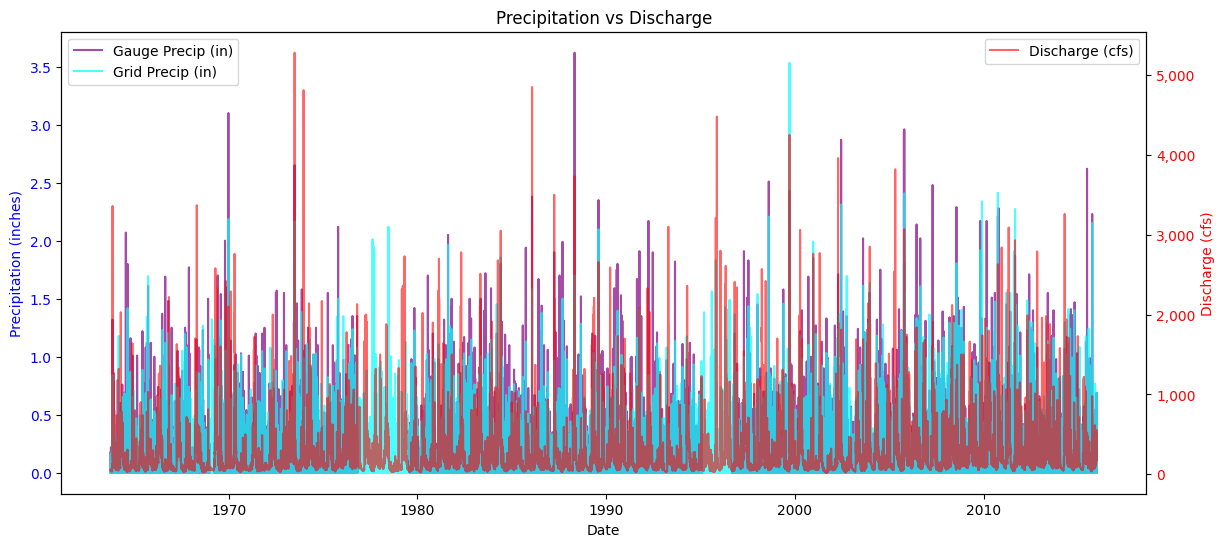

In [9]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(project.index, project['Gauge Precip (in)'], label='Gauge Precip (in)', color='purple', alpha=0.7)
ax1.plot(project.index, project['Grid Precip (in)'], label='Grid Precip (in)', color='cyan', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (inches)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(project.index, project['Discharge (cfs)'], label='Discharge (cfs)', color='red', alpha=0.6)
ax2.set_ylabel('Discharge (cfs)', color='red')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
ax1.set_title('Precipitation vs Discharge')
#initial plot of raw data

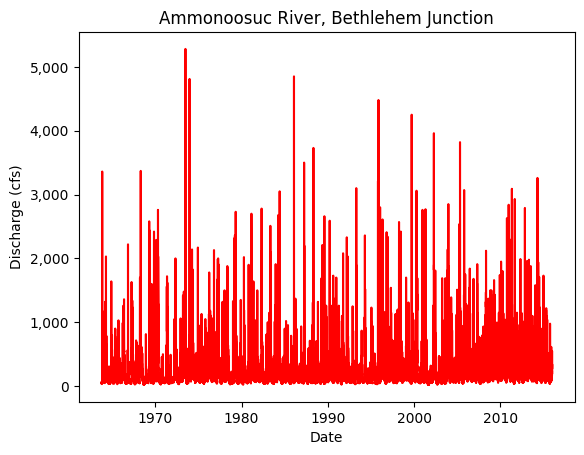

In [10]:
fig, ax = plt.subplots()
ax.plot(project.index, project['Discharge (cfs)'], label='Discharge (cfs)', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cfs)')
ax.set_title('Ammonoosuc River, Bethlehem Junction')
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

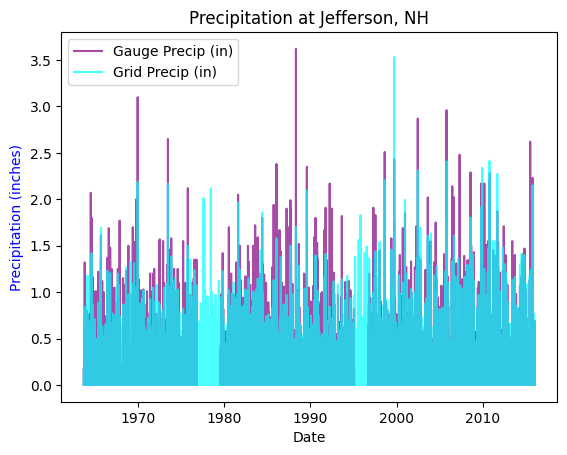

In [11]:
fig, ax = plt.subplots()
ax.plot(project.index, project['Gauge Precip (in)'], label='Gauge Precip (in)', color='purple', alpha=0.7)
ax.plot(project.index, project['Grid Precip (in)'], label='Grid Precip (in)', color='cyan', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)', color='blue')
ax.set_title('Precipitation at Jefferson, NH')
ax.legend()


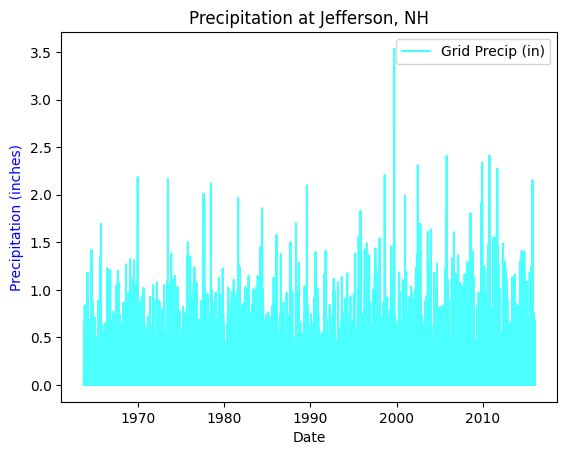

In [12]:
fig, ax = plt.subplots()
ax.plot(project.index, project['Grid Precip (in)'], label='Grid Precip (in)', color='cyan', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)', color='blue')
ax.set_title('Precipitation at Jefferson, NH')
ax.legend()


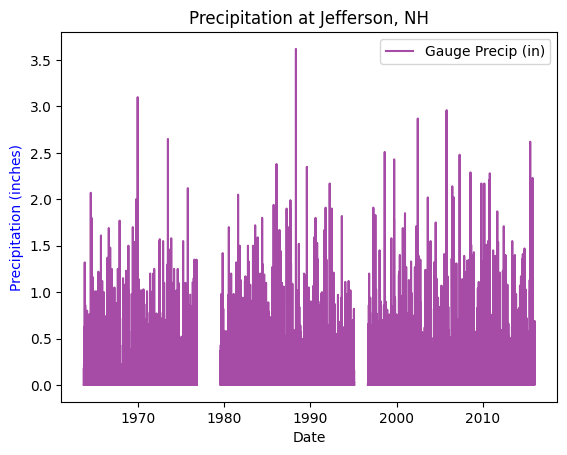

In [13]:
fig, ax = plt.subplots()
ax.plot(project.index, project['Gauge Precip (in)'], label='Gauge Precip (in)', color='purple', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)', color='blue')
ax.set_title('Precipitation at Jefferson, NH')
ax.legend()

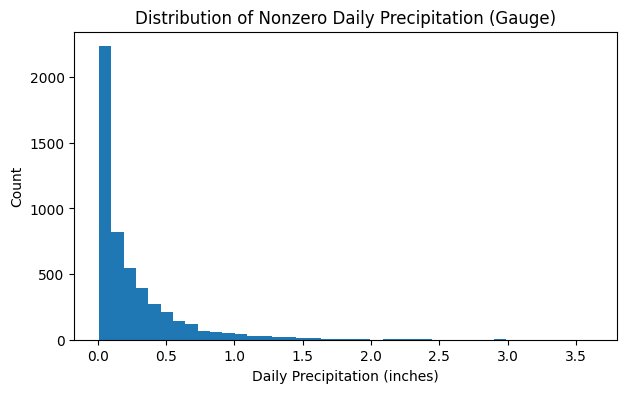

count    5121.000000
mean        0.254974
std         0.327139
min         0.010000
50%         0.140000
75%         0.340000
90%         0.640000
95%         0.920000
99%         1.548000
max         3.620000
Name: Gauge Precip (in), dtype: float64


In [14]:
pgauge = project_complete['Gauge Precip (in)'].dropna()
pgauge_nonzero = pgauge[pgauge > 0]
plt.figure(figsize=(7,4))
plt.hist(pgauge_nonzero, bins=40)
plt.xlabel('Daily Precipitation (inches)')
plt.ylabel('Count')
plt.title('Distribution of Nonzero Daily Precipitation (Gauge)')
plt.show()
print(pgauge_nonzero.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
#gauge precipitation analysis

Planned Analyses:

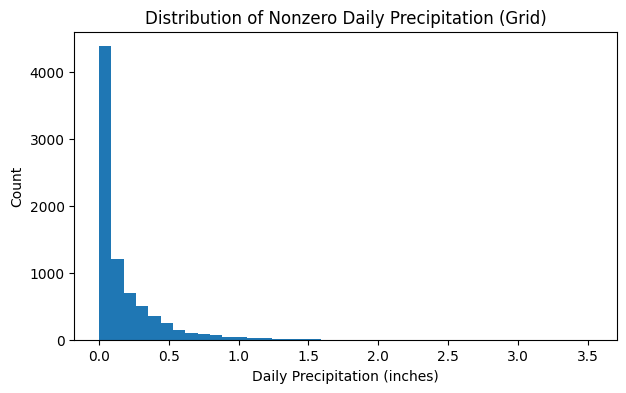

count    7976.000000
mean        0.167811
std         0.248152
min         0.000041
50%         0.068862
75%         0.219820
90%         0.452944
95%         0.655988
99%         1.167699
max         3.532893
Name: Grid Precip (in), dtype: float64


In [15]:
pgrid = project_complete['Grid Precip (in)'].dropna()
pgrid_nonzero = pgrid[pgrid > 0]
plt.figure(figsize=(7,4))
plt.hist(pgrid_nonzero, bins=40)
plt.xlabel('Daily Precipitation (inches)')
plt.ylabel('Count')
plt.title('Distribution of Nonzero Daily Precipitation (Grid)')
plt.show()
print(pgrid_nonzero.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
#grid precipitation analysis

In [16]:
def find_events_and_lags(df, precip_col='Gauge Precip (in)', q=0.9, min_gap_days=10, window_days=10, require_single_day=True):
    """
    df: DataFrame with precip and discharge columns indexed by Date
    q: percentile for threshold (e.g., 0.9)
    min_gap_days: minimum days between independent events
    window_days: days after event to search for discharge peak
    require_single_day: if True, skip events where the window contains multiple days >= threshold
    returns: DataFrame of events with lag statistics
    """
    working = df[[precip_col, 'Discharge (cfs)']].dropna()
    threshold = working[working[precip_col] > 0][precip_col].quantile(q)
    event_starts = []
    skip_until = None
    for date, rain in working[precip_col].items():
        if skip_until is not None and date <= skip_until:
            continue
        if rain >= threshold:
            event_starts.append(date)
            skip_until = date + pd.Timedelta(days=min_gap_days)
    events = []
    for start in event_starts:
        end = start + pd.Timedelta(days=window_days)
        window = working.loc[start:end]
        if window.empty:
            continue
        n_sig = (window[precip_col] >= threshold).sum()
        if require_single_day and n_sig > 1:
            continue
        peak_date = window['Discharge (cfs)'].idxmax()
        lag_days = (peak_date - start).days
        peak_q = window.loc[peak_date, 'Discharge (cfs)']
        events.append({
            'event_date': start,
            'peak_date': peak_date,
            'lag_days': lag_days,
            'peak_discharge': peak_q,
            'rain_amount': working.loc[start, precip_col],
            'n_sig_days_in_window': n_sig
        })
    events_df = pd.DataFrame(events)
    return events_df, threshold

90th percentile threshold: 0.64 in
Filtered to 217 clean single-storm events.
    event_date  lag_days  rain_amount  peak_discharge
0   1964-10-21         7         1.16           166.0
1   1965-02-25         9         1.01            90.0
2   1965-06-22         2         0.78           267.0
3   1965-08-10         0         1.08           213.0
4   1965-09-25         0         1.61          1030.0
..         ...       ...          ...             ...
212 2015-01-19         0         0.72           716.0
213 2015-08-12         0         0.99           274.0
214 2015-08-26         0         0.75            80.5
215 2015-09-15         0         0.79           103.0
216 2015-09-30         0         2.23           978.0

[217 rows x 4 columns]

Lag time summary:
count    217.000000
mean       1.760369
std        2.829687
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       10.000000
Name: lag_days, dtype: float64


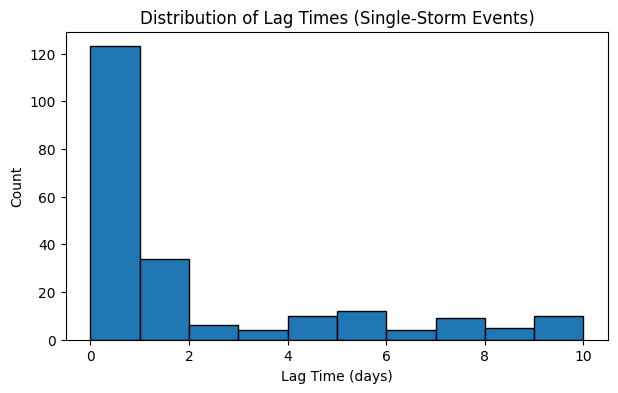

        count      mean       std  min  25%  50%  75%   max
season                                                     
Winter   31.0  2.838710  3.541156  0.0  0.0  1.0  5.0  10.0
Spring   55.0  2.600000  3.297586  0.0  0.0  1.0  5.0  10.0
Summer   64.0  1.250000  2.145501  0.0  0.0  0.0  1.0   9.0
Fall     67.0  1.059701  2.308618  0.0  0.0  0.0  1.0  10.0


C:\Users\ryano\AppData\Local\Temp\ipykernel_24420\1140700210.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(events_df.groupby('season')['lag_days'].describe())


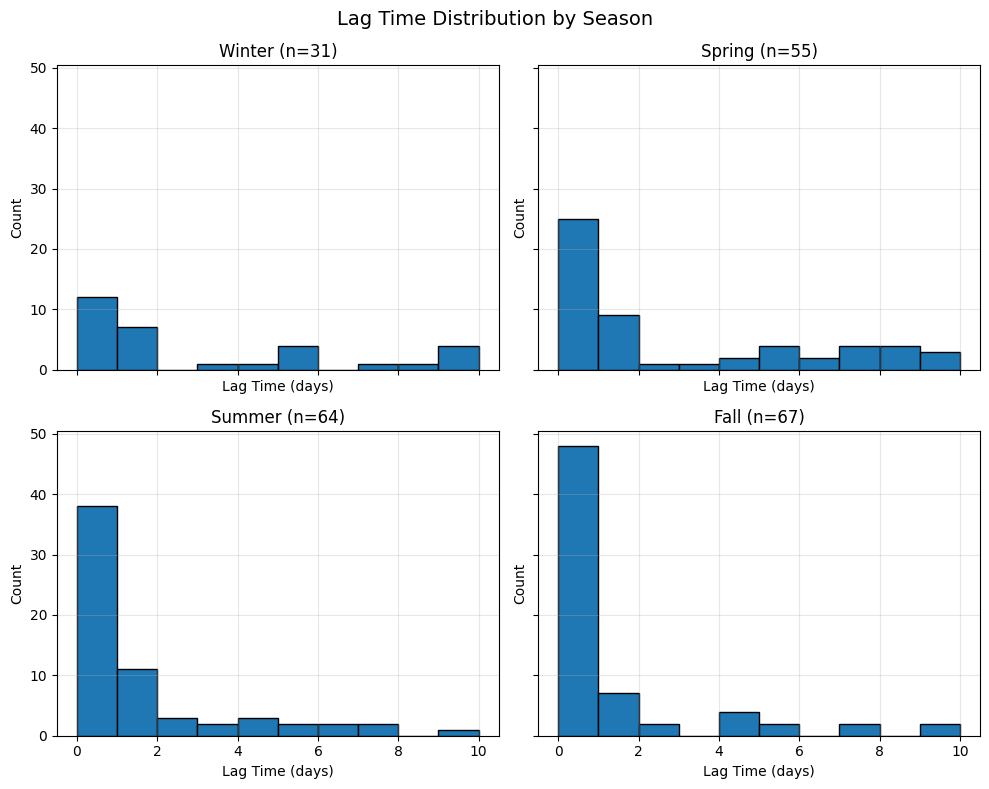

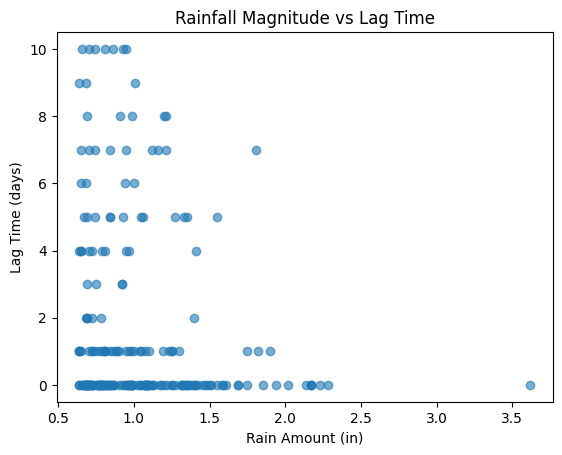

In [17]:
events_df, threshold = find_events_and_lags(project_complete, q=0.9, min_gap_days=10, window_days=10, require_single_day=True)
print(f"90th percentile threshold: {threshold:.2f} in")
print(f"Filtered to {len(events_df)} clean single-storm events.")
if not events_df.empty:
    print(events_df[['event_date', 'lag_days', 'rain_amount', 'peak_discharge']])
    print("\nLag time summary:")
    print(events_df['lag_days'].describe())

    plt.figure(figsize=(7, 4))
    plt.hist(events_df['lag_days'], bins=range(0, 11), edgecolor='black')
    plt.xlabel('Lag Time (days)')
    plt.ylabel('Count')
    plt.title('Distribution of Lag Times (Single-Storm Events)')
    plt.show()
    events_df = events_df.copy()
    events_df['month'] = events_df['event_date'].dt.month
    events_df['season'] = pd.cut(events_df['month'], bins=[0, 3, 6, 9, 12],
                                 labels=['Winter', 'Spring', 'Summer', 'Fall'],
                                 include_lowest=True, right=False)
    events_df.loc[events_df['month'].isin([12, 1, 2]), 'season'] = 'Winter'
    print(events_df.groupby('season')['lag_days'].describe())
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    bins = range(0, 11)
    for ax, season in zip(axes, seasons):
        subset = events_df[events_df['season'] == season]['lag_days']
        ax.hist(subset, bins=bins, edgecolor='black')
        ax.set_title(f'{season} (n={len(subset)})')
        ax.set_xlabel('Lag Time (days)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
    fig.suptitle('Lag Time Distribution by Season', fontsize=14)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.scatter(events_df['rain_amount'], events_df['lag_days'], alpha=0.6)
    plt.xlabel('Rain Amount (in)')
    plt.ylabel('Lag Time (days)')
    plt.title('Rainfall Magnitude vs Lag Time')
    plt.show()
else:
    print("No events found after filtering.")


In [18]:
#Mann-Kendall Trend Test Precipitation Analysis
series = project_complete['Gauge Precip (in)'].resample('YE').sum()
result = mk.original_test(series)
print(result)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(1.2854861790367877e-05), z=np.float64(4.362561186326186), Tau=np.float64(0.4155354449472097), s=np.float64(551.0), var_s=np.float64(15894.333333333334), slope=np.float64(0.5355357142857142), intercept=np.float64(18.073839285714286))


In [19]:
# Mann-Kendall Trend Test Precipitation Analysis Grid
series2 = project_complete['Grid Precip (in)'].resample('YE').sum()
result2 = mk.original_test(series2)
print(result2)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(2.1233006915810648e-05), z=np.float64(4.251514174310611), Tau=np.float64(0.40497737556561086), s=np.float64(537.0), var_s=np.float64(15894.333333333334), slope=np.float64(0.5099307004507485), intercept=np.float64(18.248441790605522))


In [20]:
#Mann-Kendall Trend Test Lag Time Analysis
lag_series = events_df.set_index('event_date')['lag_days']
result3 = mk.original_test(lag_series)
print(result3)

Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.021309089383470647), z=np.float64(-2.3024627568849825), Tau=np.float64(-0.09472606246799795), s=np.float64(-2220.0), var_s=np.float64(928815.3333333334), slope=np.float64(0.0), intercept=np.float64(0.0))


In [21]:
#Stat test for difference between gauge and grid precip
df = project_complete.dropna(subset=['Gauge Precip (in)', 'Grid Precip (in)'])
# daily difference
df['diff'] = df['Gauge Precip (in)'] - df['Grid Precip (in)']
# run Wilcoxon on the paired differences
stat, pval = wilcoxon(df['diff'])
print(f"Wilcoxon stat: {stat}")
print("Exact p-value:", "{:.3e}".format(pval))
print(df['diff'].describe())
print("Median difference:", df['diff'].median())
print("Mean difference:", df['diff'].mean())
#Shows median difference between gauge and grid precip is -.002

Wilcoxon stat: 13765197.0
Exact p-value: 3.000e-33
count    12053.000000
mean        -0.002717
std          0.133895
min         -1.411110
25%         -0.017727
50%          0.000000
75%          0.000000
max          1.917898
Name: diff, dtype: float64
Median difference: 0.0
Mean difference: -0.0027165412306476714


In [22]:
project_complete['diff'] = project_complete['Gauge Precip (in)'] - project_complete['Grid Precip (in)']
project_complete['diff'].median()
project_complete

,Gauge Precip (in),Grid Precip (in),Discharge (cfs),water_year,diff
Date,,,,,
1964-10-01,0.00,0.000000,39.0,1965,0.000000
1964-10-02,0.00,0.000000,38.0,1965,0.000000
1964-10-03,0.36,0.315767,62.0,1965,0.044233
1964-10-04,0.00,0.000000,60.0,1965,0.000000
1964-10-05,0.00,0.000000,46.0,1965,0.000000
...,...,...,...,...,...
2015-09-26,0.00,0.000000,37.3,2015,0.000000
2015-09-27,0.00,0.000000,36.7,2015,0.000000
2015-09-28,0.00,0.000000,36.4,2015,0.000000


In [23]:
df_thresh = df[(df["Grid Precip (in)"] > 0.45) & (df["Gauge Precip (in)"] > 0.45)]
len(df_thresh)

586

In [24]:
df_thresh["diff"] = df_thresh["Grid Precip (in)"] - df_thresh["Gauge Precip (in)"]
stat, p = wilcoxon(df_thresh["Grid Precip (in)"], df_thresh["Gauge Precip (in)"])
print("Wilcoxon stat:", stat)
print("Exact p-value:", f"{p:.3e}")

Wilcoxon stat: 48761.0
Exact p-value: 1.076e-19


C:\Users\ryano\AppData\Local\Temp\ipykernel_24420\1063522089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_thresh["diff"] = df_thresh["Grid Precip (in)"] - df_thresh["Gauge Precip (in)"]


Finding the associated lag time between large precipitation events and associated higher flows at the watershed outlet. Additionally running a statistical test finding what a "large" precip event is.

Recurrence Interval/Exceedance Probability calcs/plot of both gauge precipitation, grid precipitation, and discharge.

Statistical test of if the difference between the reanalysis and gauge data are statistically signifcant. Ie can we trust the reanalysis data.

Statistical analysis of if the precipitation or discharge is increasing over time.

Discussion/Conclusion:

What is the lag time between events?

Is there a difference between both types of precipitation data? There does appear to be variation looking at the raw data.

What is the result of the test analyzing increasing trends in precip/discharge over time.